In [1]:
import zipfile
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#!unzip "/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip" -d "/content/gdrive/MyDrive/Upgrad/CNN_assignment"

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model

from glob import glob



**Data Reading/ Data Understanding**

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Dataset Creation**

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                              data_dir_train,
                                                              batch_size=batch_size,
                                                              image_size=(img_height,img_width),
                                                              label_mode='categorical',
                                                              validation_split=0.2,
                                                              subset="training",
                                                              seed=123
                                                             )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                              data_dir_train,
                                                              batch_size=batch_size,
                                                              image_size=(img_height,img_width),
                                                              label_mode='categorical',
                                                              validation_split=0.2,
                                                              subset="validation",
                                                              seed=123
                                                             )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                                data_dir_test,
                                                                batch_size=batch_size,
                                                                image_size=(img_height,img_width),
                                                                label_mode='categorical',
                                                                seed=123
                                                              )

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Data Visualisation**

code to visualize one instance of all the nine classes present in the dataset

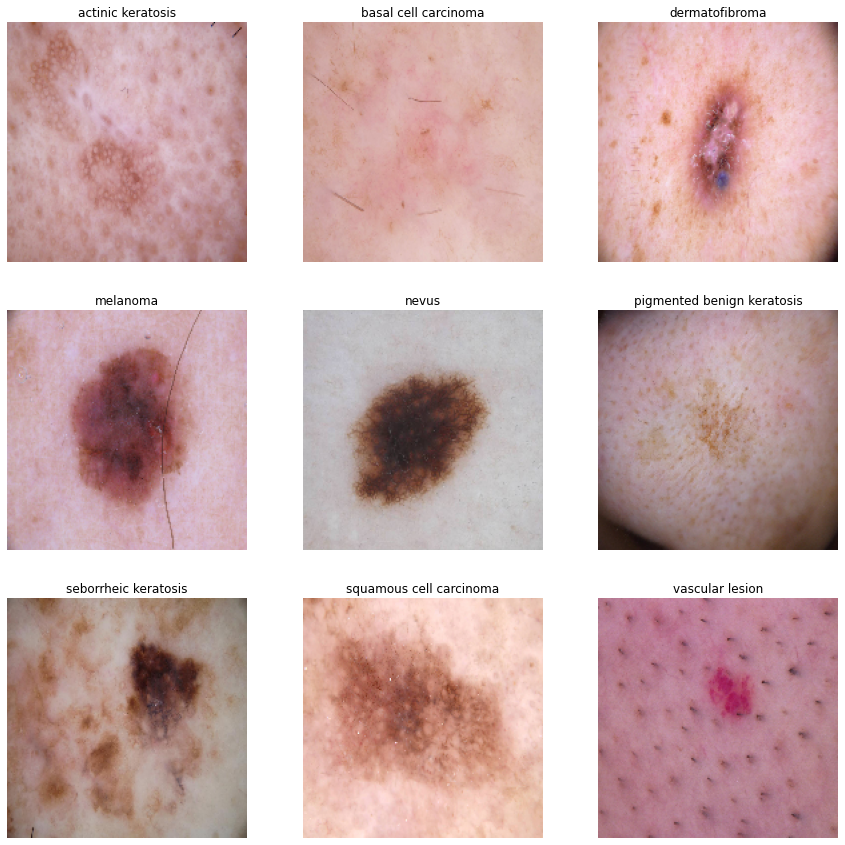

In [11]:
#Dictionary to store the path of image as per the class
files_path = {}

for c in class_names:
    files_path[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

> Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]







The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

#Rescaling Layer to normalize pixel values between (0,1)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255.00,input_shape=(180,180,3)))   

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.30))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

**Compile the model**
> Choose an appropirate optimiser and loss function for model training



In [15]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

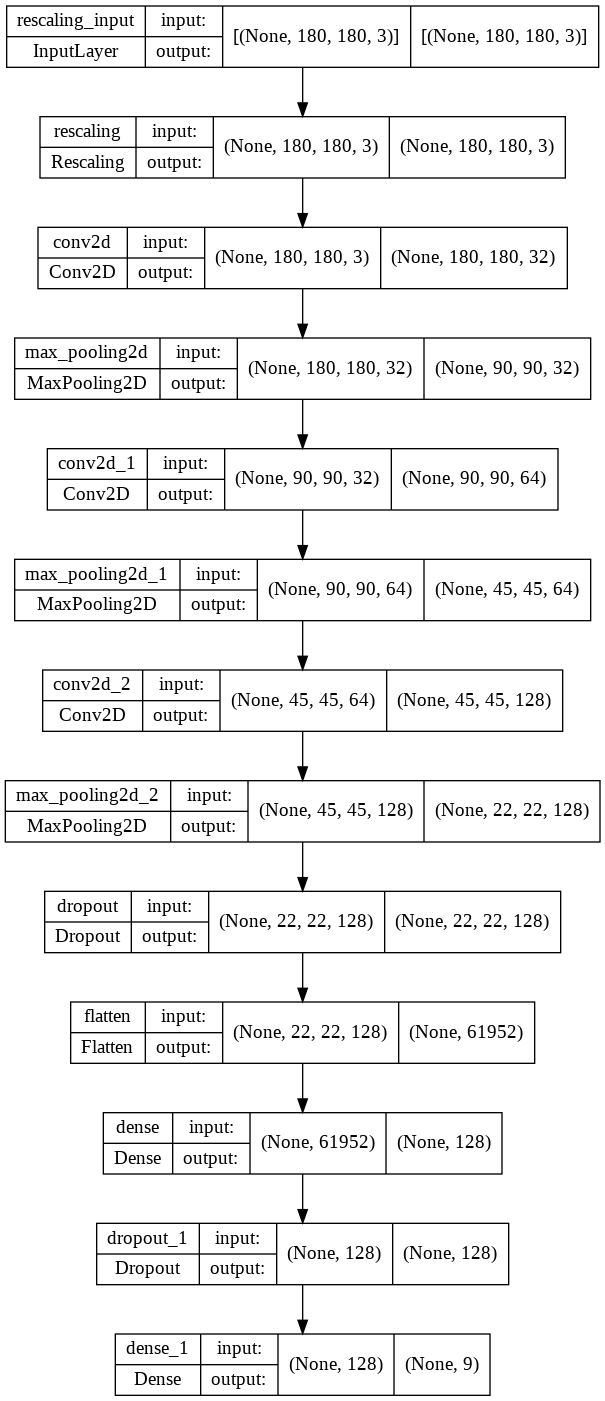

In [16]:
# vizualizing the model 

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Train the model**

In [17]:
#train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 1066s 3s/step - loss: 1.8883 - accuracy: 0.2917 - val_loss: 1.5551 - val_accuracy: 0.4120
Epoch 2/20
169/169 [==============================] - 369s 2s/step - loss: 1.5128 - accuracy: 0.4293 - val_loss: 1.3964 - val_accuracy: 0.4595
Epoch 3/20
169/169 [==============================] - 370s 2s/step - loss: 1.3107 - accuracy: 0.5089 - val_loss: 1.2079 - val_accuracy: 0.5509
Epoch 4/20
169/169 [==============================] - 367s 2s/step - loss: 1.2049 - accuracy: 0.5430 - val_loss: 1.1426 - val_accuracy: 0.5605
Epoch 5/20
169/169 [==============================] - 371s 2s/step - loss: 1.0764 - accuracy: 0.5892 - val_loss: 1.0117 - val_accuracy: 0.6273
Epoch 6/20
169/169 [==============================] - 370s 2s/step - loss: 0.9758 - accuracy: 0.6337 - val_loss: 0.9636 - val_accuracy: 0.6414
Epoch 7/20
169/169 [==============================] - 368s 2s/step - loss: 0.8772 - accuracy: 0.6747 - val_loss: 0.8684 - val_accuracy: 0.691

**Visualizing training results**

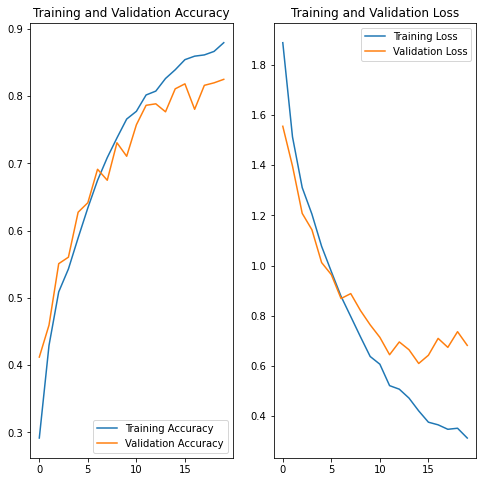

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**findings**

> Training accuracy is high(.8793) and loss is low(0.31) whereas Validation accuracy is near to training accuracy(.82) and loss is high(0.68). This means model is not performing well on unseen data and is case of overfitting.



**Data Augmentation - Manual** 

In [19]:
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator rotation
datagen = ImageDataGenerator(
                                rotation_range=30, 
                                fill_mode='nearest',
                                rescale=1.0/255.0,
                                validation_split=0.2
                             )


In [20]:
data_dir_manual_aug = "/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Augment"

In [21]:
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [22]:
train_ds_manual_aug = datagen.flow_from_directory(
                                            data_dir_manual_aug, 
                                            target_size = (img_height, img_width),
                                            classes = class_names,
                                            batch_size = batch_size,
                                            subset="training",
                                            seed=123
                                          )

Found 1795 images belonging to 9 classes.


In [23]:
val_ds_manual_aug = datagen.flow_from_directory(
                                            data_dir_manual_aug, 
                                            target_size = (img_height, img_width),
                                            classes = class_names,
                                            batch_size = batch_size,
                                            subset="validation",
                                            seed=123
                                          )

Found 444 images belonging to 9 classes.


In [24]:
## Create the model

model_manual_aug = Sequential()

#Rescaling Layer to normalize pixel values between (0,1)
model_manual_aug.add(layers.experimental.preprocessing.Rescaling(1.0/255.00,input_shape=(180,180,3)))   

#First Convulation layer
model_manual_aug.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model_manual_aug.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model_manual_aug.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model_manual_aug.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 30% Fraction of the input units to drop.
model_manual_aug.add(layers.Dropout(0.30))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_manual_aug.add(layers.Flatten())

#Dense Layer
model_manual_aug.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model_manual_aug.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_manual_aug.add(layers.Dense(len(class_names),activation='softmax'))

In [25]:
# View the summary of all layers
model_manual_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

In [26]:
# compile the model
model_manual_aug.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
#train the model
epochs = 20
history_manual_aug = model_manual_aug.fit(
                                            train_ds_manual_aug,
                                            #batch_size=batch_size,
                                            validation_data=val_ds_manual_aug,
                                            epochs=epochs
                                          )

Epoch 1/20
57/57 [==============================] - 477s 8s/step - loss: 2.0609 - accuracy: 0.1911 - val_loss: 2.0269 - val_accuracy: 0.2072
Epoch 2/20
57/57 [==============================] - 158s 3s/step - loss: 2.0505 - accuracy: 0.1889 - val_loss: 2.0130 - val_accuracy: 0.2072
Epoch 3/20
57/57 [==============================] - 158s 3s/step - loss: 2.0406 - accuracy: 0.1967 - val_loss: 2.0130 - val_accuracy: 0.2072
Epoch 4/20
57/57 [==============================] - 164s 3s/step - loss: 2.0338 - accuracy: 0.1961 - val_loss: 2.0145 - val_accuracy: 0.2072
Epoch 5/20
57/57 [==============================] - 157s 3s/step - loss: 2.0425 - accuracy: 0.2033 - val_loss: 2.0266 - val_accuracy: 0.2072
Epoch 6/20
57/57 [==============================] - 157s 3s/step - loss: 2.0307 - accuracy: 0.2111 - val_loss: 2.0221 - val_accuracy: 0.2072
Epoch 7/20
57/57 [==============================] - 156s 3s/step - loss: 2.0294 - accuracy: 0.1900 - val_loss: 2.0211 - val_accuracy: 0.2072
Epoch 8/20
57

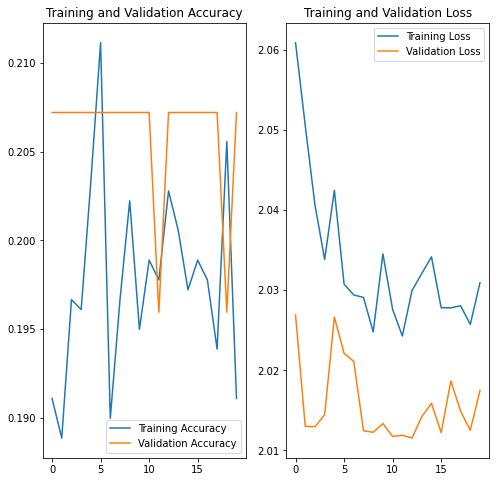

In [28]:
acc = history_manual_aug.history['accuracy']
val_acc = history_manual_aug.history['val_accuracy']

loss = history_manual_aug.history['loss']
val_loss = history_manual_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**findings**

> Rotation of images to 30 degree didn't help, very low accuracy and high loss on both training and validation. This means model is not performing well on both seen and unseen data and is case of underfitting.

**Class Distribution**

In [29]:
#Find the distribution of classes in the training dataset
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)

In [30]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [31]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
print(original_df.Label.value_counts())

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64


Text(0.5, 1.0, 'Image Count per Class')

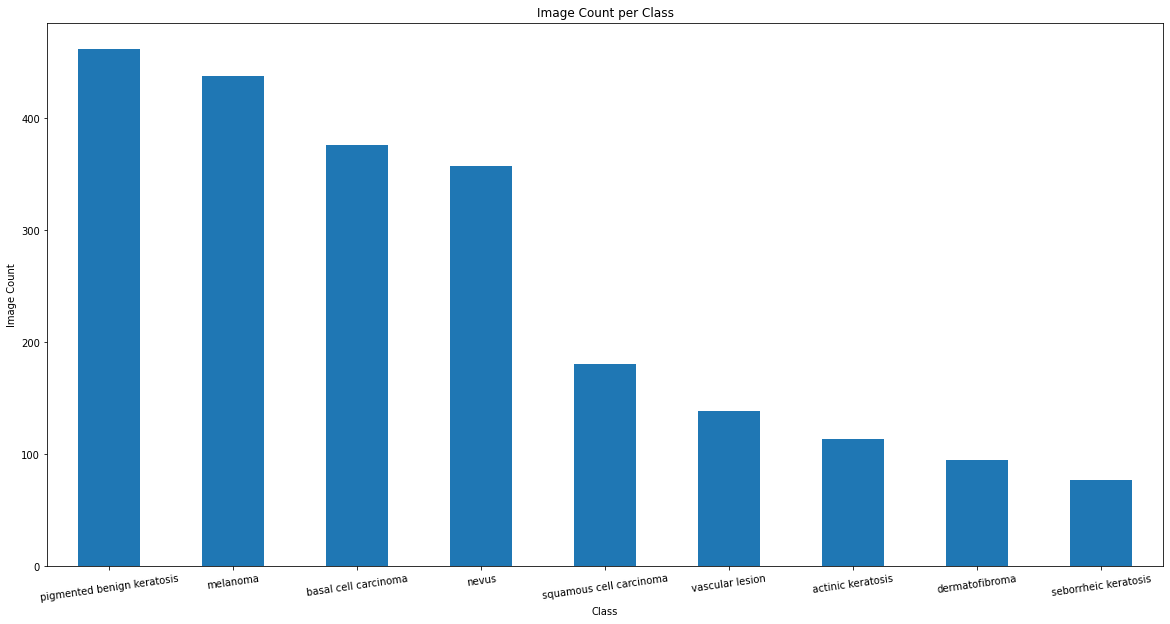

In [32]:
#visualize the class class distribution

original_df.Label.value_counts().plot(kind='bar', figsize=(20, 10), rot=8)
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.title("Image Count per Class")

**Findings**

*   seborrheic keratosis class has the least number of samples
*   melanoma and basal cell carcinoma classes dominate the data in terms proportionate number of samples

In [33]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Handling class imbalances**


In [34]:
path_to_training_dataset="/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A39A69D10>: 100%|██████████| 500/500 [00:26<00:00, 18.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A39304810>: 100%|██████████| 500/500 [00:27<00:00, 18.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0A39A69690>: 100%|██████████| 500/500 [00:28<00:00, 17.30 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F0A399EA990>: 100%|██████████| 500/500 [01:49<00:00,  4.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2583x2096 at 0x7F0A39A5EF10>: 100%|██████████| 500/500 [01:46<00:00,  4.68 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A39B1A8D0>: 100%|██████████| 500/500 [00:23<00:00, 21.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0A399BC7D0>: 100%|██████████| 500/500 [00:52<00:00,  9.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A39B1FBD0>: 100%|██████████| 500/500 [00:27<00:00, 18.02 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A39A49790>: 100%|██████████| 500/500 [00:31<00:00, 15.66 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_b3ede297-85a2-46ca-8da6-78a38d5ca0d3.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_bd1c2189-292f-4111-a7c4-8917d42e3699.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028820.jpg_a7301d73-0037-4e57-bc7e-2f9afbe19e2c.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_eabe7616-6388-41cb-9ba7-c025125f6c1c.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin 

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

**Train the model on the data created using Augmentor** 

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                                data_dir_train,
                                                                seed=123,
                                                                validation_split = 0.2,
                                                                subset = "training",
                                                                image_size = (img_height, img_width),
                                                                batch_size = batch_size
                                                               )

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                              data_dir_train,
                                                              seed=123,
                                                              validation_split = 0.2,
                                                              subset = "validation",
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size
                                                             )

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [42]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model_Augmentor = Sequential()

#Rescaling Layer to normalize pixel values between (0,1)
model_Augmentor.add(layers.experimental.preprocessing.Rescaling(1.0/255.00,input_shape=(180,180,3)))   

#First Convulation layer
model_Augmentor.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model_Augmentor.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model_Augmentor.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model_Augmentor.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 30% Fraction of the input units to drop.
model_Augmentor.add(layers.Dropout(0.30))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_Augmentor.add(layers.Flatten())

#Dense Layer
model_Augmentor.add(layers.Dense(128,activation='relu'))

#Dropout layer with 30% Fraction of the input units to drop.
model_Augmentor.add(layers.Dropout(0.30))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_Augmentor.add(layers.Dense(len(class_names),activation='softmax'))

In [43]:
# View the summary of all layers
model_Augmentor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [44]:
# compile the model
model_Augmentor.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

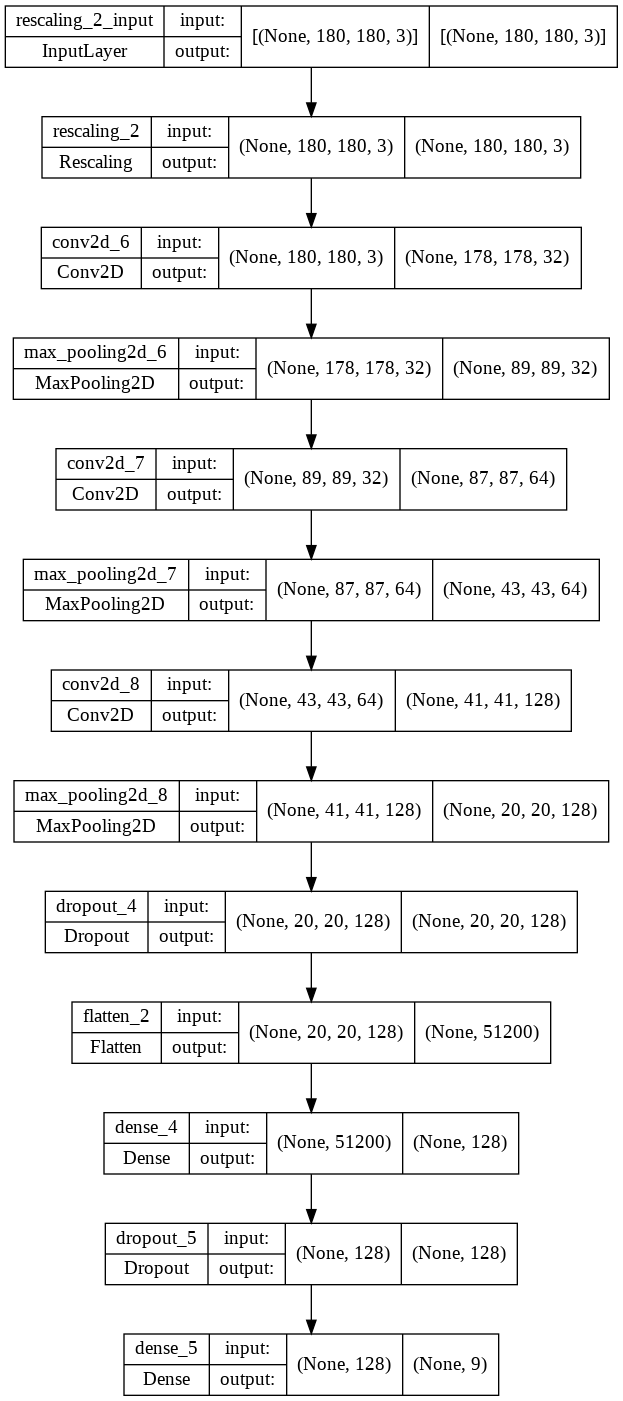

In [45]:
# vizualizing the model 

plot_model(model_Augmentor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [46]:
#train the model
epochs = 30
history_Augmentor = model_Augmentor.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 628s 2s/step - loss: 1.7566 - accuracy: 0.3282 - val_loss: 1.4609 - val_accuracy: 0.4263
Epoch 2/30
281/281 [==============================] - 608s 2s/step - loss: 1.3708 - accuracy: 0.4812 - val_loss: 1.1750 - val_accuracy: 0.5376
Epoch 3/30
281/281 [==============================] - 598s 2s/step - loss: 1.1953 - accuracy: 0.5547 - val_loss: 1.1048 - val_accuracy: 0.5986
Epoch 4/30
281/281 [==============================] - 609s 2s/step - loss: 1.0761 - accuracy: 0.5980 - val_loss: 1.0736 - val_accuracy: 0.6053
Epoch 5/30
281/281 [==============================] - 602s 2s/step - loss: 0.9051 - accuracy: 0.6657 - val_loss: 0.7440 - val_accuracy: 0.7330
Epoch 6/30
281/281 [==============================] - 604s 2s/step - loss: 0.7836 - accuracy: 0.7038 - val_loss: 0.6522 - val_accuracy: 0.7579
Epoch 7/30
281/281 [==============================] - 602s 2s/step - loss: 0.6815 - accuracy: 0.7476 - val_loss: 0.6883 - val_accuracy: 0.7708

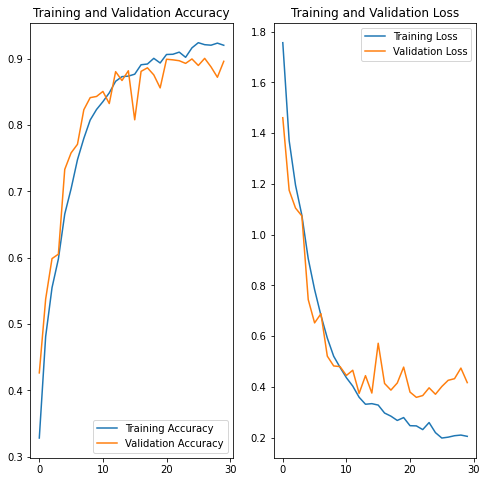

In [47]:
acc = history_Augmentor.history['accuracy']
val_acc = history_Augmentor.history['val_accuracy']

loss = history_Augmentor.history['loss']
val_loss = history_Augmentor.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**

There is high train accuracy(0.92) and validation accurancy (0.89) and difference between is less
There is low train loss(0.2) and validation loss (0.4).



**there is scope to reduce to the loss further.**
